In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error

In [2]:
data_red = pd.read_csv('winequality-red.csv', delimiter=';')
data_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
data_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


**Пропуски та категоріальні фічі відсутні. Основний тип даних - флоат, таргет - якість, інт. Є лише загвоздка з таргетом, що модель розраховує як флоат а не ціле число ((це мабуть можна вважати частково категоріальною колонкою?)), тому можна застосувати округлення в кінці і результати виходять доволі непоганими**

In [4]:
data_white = pd.read_csv('winequality-white.csv', delimiter=';')
data_white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [5]:
data_white.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


**Пропуски та категоріальні фічі відсутні. Основний тип даних - флоат, таргет - якість, інт**

<Axes: >

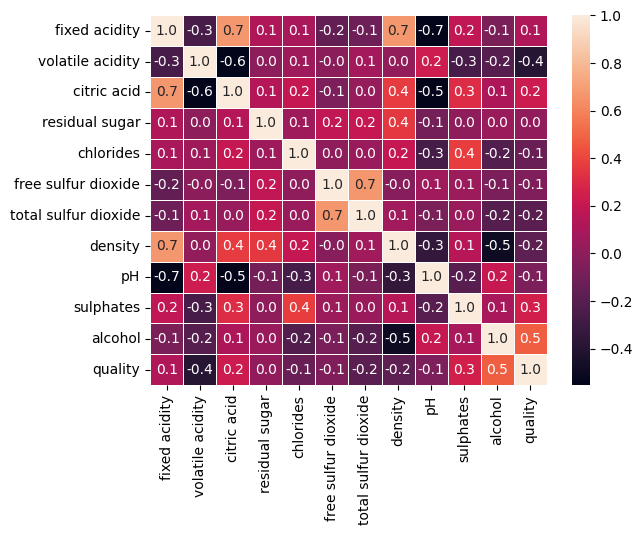

In [6]:
corr_matrix = data_red.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".1f", linewidth=.5, robust=True)

**Кореляції вищої за 0.8 не спостерігається, не потрібно підчищати фічі**

<Axes: >

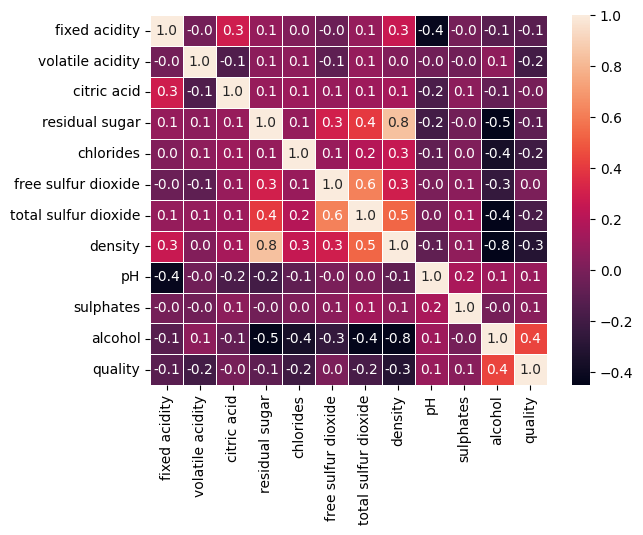

In [7]:
corr_matrix = data_white.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".1f", linewidth=.5, robust=True)

**Між density та residual sugar кореляція більша за 0.8 якщо подивитися в нескороченому стані, треба прибрати одну з фічей для тренування моделі, між density та quality зв'язок слабший, приберемо цю фічу.**

<Axes: >

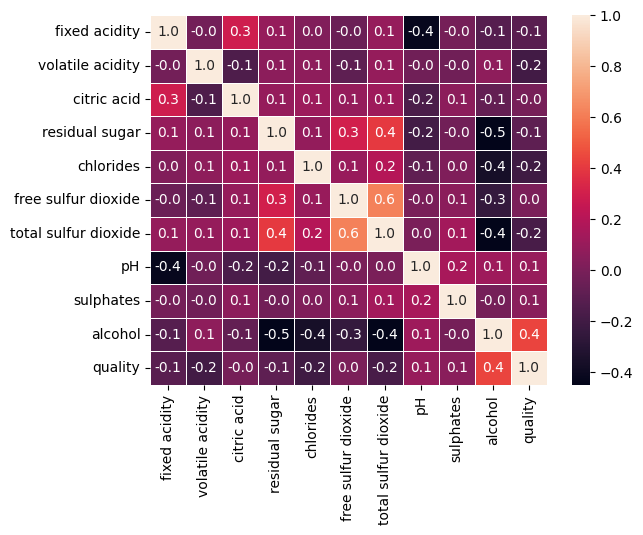

In [8]:
data_white = data_white.drop(columns='density')
corr_matrix = data_white.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".1f", linewidth=.5, robust=True)

**Тепер з білими винами немає проблем, висока кореляція прибрана**


In [9]:
data_red['max_acidity'] = data_red['fixed acidity'] + data_red['volatile acidity']
data_red['part_citric_acid'] = (data_red['citric acid'] / data_red['max_acidity'])
data_red['sulfur dioxide'] = data_red['free sulfur dioxide'] + data_red['total sulfur dioxide']
data_red = data_red.drop(columns=['fixed acidity', 'citric acid', 'free sulfur dioxide', 'total sulfur dioxide'])
data_red.head()

,volatile acidity,residual sugar,chlorides,density,pH,sulphates,alcohol,quality,max_acidity,part_citric_acid,sulfur dioxide
0,0.70,1.9,0.076,0.9978,3.51,0.56,9.4,5,8.10,0.000000,45.0
1,0.88,2.6,0.098,0.9968,3.20,0.68,9.8,5,8.68,0.000000,92.0
2,0.76,2.3,0.092,0.9970,3.26,0.65,9.8,5,8.56,0.004673,69.0
3,0.28,1.9,0.075,0.9980,3.16,0.58,9.8,6,11.48,0.048780,77.0
4,0.70,1.9,0.076,0.9978,3.51,0.56,9.4,5,8.10,0.000000,45.0


In [10]:
data_white['max_acidity'] = data_white['fixed acidity'] + data_white['volatile acidity']
data_white['part_citric_acid'] = (data_white['citric acid'] / data_white['max_acidity'])
data_white = data_white.drop(columns=['fixed acidity', 'citric acid'])
data_white.head()

,volatile acidity,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates,alcohol,quality,max_acidity,part_citric_acid
0,0.27,20.7,0.045,45.0,170.0,3.00,0.45,8.8,6,7.27,0.049519
1,0.30,1.6,0.049,14.0,132.0,3.30,0.49,9.5,6,6.60,0.051515
2,0.28,6.9,0.050,30.0,97.0,3.26,0.44,10.1,6,8.38,0.047733
3,0.23,8.5,0.058,47.0,186.0,3.19,0.40,9.9,6,7.43,0.043069
4,0.23,8.5,0.058,47.0,186.0,3.19,0.40,9.9,6,7.43,0.043069


**Створили нові більш косплексні фічі максимальної кислотності та частини лимонної кислоти у складі, старі задіяні фічі (volatile корелює не сильно, не заважає, подивився по heatmap, не видаляв) видаляємо щоб позбавитись кореляцій**

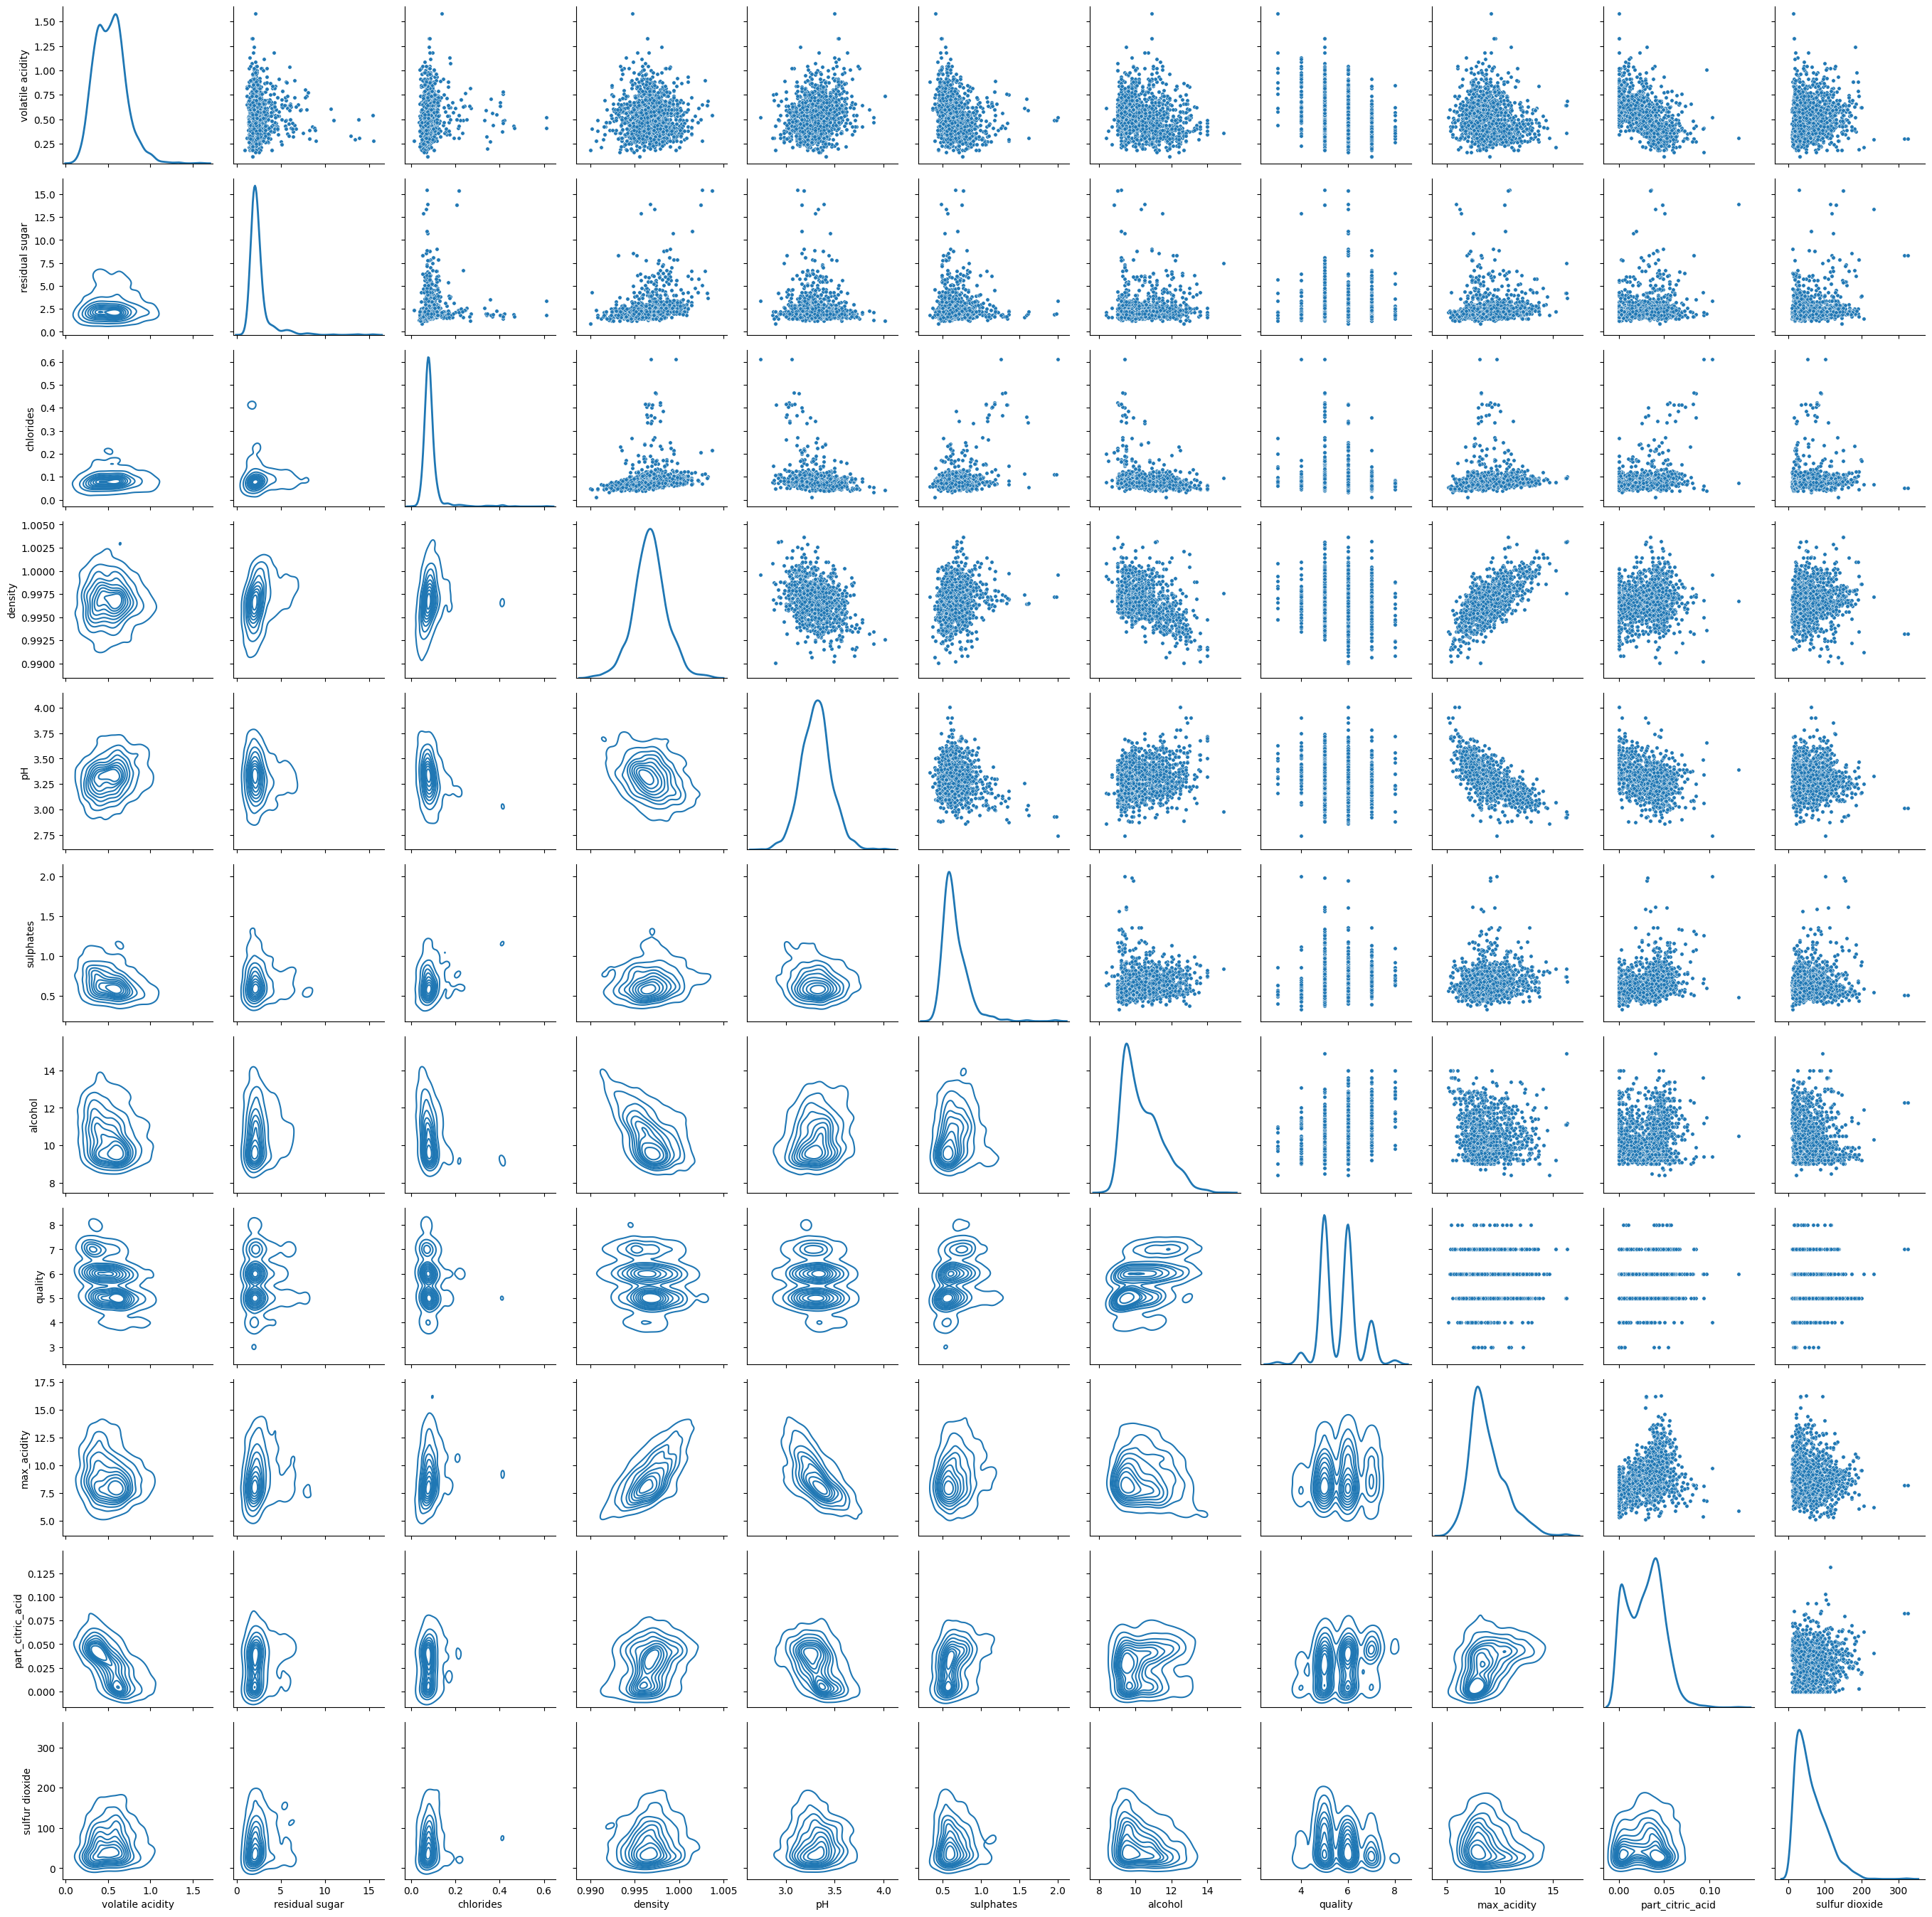

In [11]:
g = sns.PairGrid(data_red, diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

**Прослідковуються незначні залежності у деяких фіч, але в цілому не значно та немає чогось явного щоб виділити. Зате видно аутлаєри, прибирати не будемо, вони необхідні для побудови даної моделі, бо загалом це пов'язно з не часто повторюваними значеннями якості**

**Дані готові. Спочатку розберемось з червоними винами, потім перейдемо до білих**

In [12]:
scaler = StandardScaler()
data_red_sc = scaler.fit_transform(data_red.drop(columns='quality'))
X_train, X_test, y_train, y_test = train_test_split(data_red_sc, data_red.quality, train_size=.66, random_state=17, shuffle=True, stratify=data_red.quality)

**Застосували Масштабування до даних та розділили на тренувальну/тестову частини**

In [13]:
reg = LinearRegression()

cv_sc = cross_val_score(reg, X_train, y_train, cv=4)
print(f"Cross-Validation Scores: {cv_sc}")

Cross-Validation Scores: [0.35515336 0.40846402 0.35375415 0.32699482]


In [14]:
reg.fit(X_train, y_train)

print(f'Train Score: {reg.score(X_train, y_train)}')
print(f'Test Score: {reg.score(X_test, y_test)}')

Train Score: 0.38101578833681304
Test Score: 0.2997929912190752


**Тренування базової моделі із дефолтними гіперпараметрами. За крос валідацією дані не зовсім збалансовані, є відхилення. Трейн та Тест скори у нормі, в нормальному проміжку**

In [15]:
def error_est(model, X_train, X_test, y_train, y_test):
    y_train_pred = np.around(model.predict(X_train), 0)
    y_test_pred = np.around(model.predict(X_test), 0)

    return {
        "MSE Train": round(mean_squared_error(y_train, y_train_pred), 3),
        "MSE Test": round(mean_squared_error(y_test, y_test_pred), 3),
        "RMSE Train": round(root_mean_squared_error(y_train, y_train_pred), 3),
        "RMSE Test": round(root_mean_squared_error(y_test, y_test_pred), 3),
        "MAE Train": round(mean_absolute_error(y_train, y_train_pred), 3),
        "MAE Test": round(mean_absolute_error(y_test, y_test_pred), 3),
    }

error_est(reg, X_train, X_test, y_train, y_test)

{'MSE Train': 0.482,
 'MSE Test': 0.537,
 'RMSE Train': 0.695,
 'RMSE Test': 0.733,
 'MAE Train': 0.418,
 'MAE Test': 0.471}

**Створюємо функцію, що оцінює помилки моделі та дивимось на помилки моделі з дефолтними гіперпараметрами. Між тренувальними та тестовими даними існує невелика розбіжність, але взагалому модель не перетренувалась. Помилки існують та їх доволі немало**

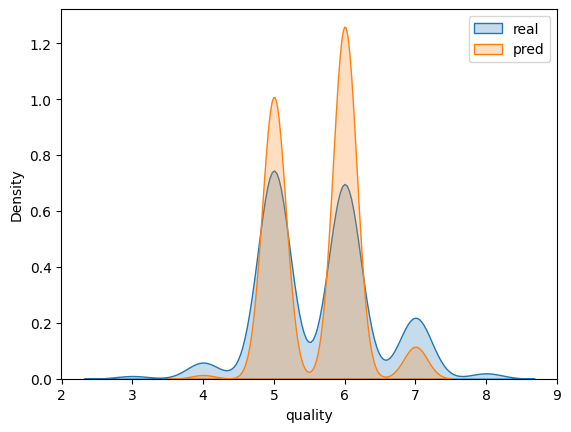

In [16]:
sns.kdeplot(y_test, fill=True, label='real')
sns.kdeplot(np.around(reg.predict(X_test), 0), fill=True, label='pred')
plt.legend()

**Модель має чіткі викиди в якості 5-6, але загалом значення доволі непогано співпадають з реальними. Модель не охопила крайні значення якості**

In [17]:
sgd_reg = SGDRegressor(penalty='elasticnet')
# penalty elasticnet поєднує в собі l1 i l2 регуляризацію
param_grid = {
    'alpha': np.linspace(0.001, 2, 100),
    'l1_ratio': np.linspace(0.01, 0.99, 10),
    'random_state': [17, 42],
}
grid_search_cv = GridSearchCV(sgd_reg, param_grid, cv=4, scoring='neg_mean_squared_error')
grid_search_cv.fit(X_train, y_train)
best_model = grid_search_cv.best_estimator_



print("Best Model:", best_model)

error_est(best_model, X_train, X_test, y_train, y_test)

Best Model: SGDRegressor(alpha=0.041383838383838384, l1_ratio=0.44555555555555554,
             penalty='elasticnet', random_state=42)


{'MSE Train': 0.487,
 'MSE Test': 0.546,
 'RMSE Train': 0.698,
 'RMSE Test': 0.739,
 'MAE Train': 0.427,
 'MAE Test': 0.476}

**Модель майже не перенавчена, є деяка різниця між трейном та тестом**

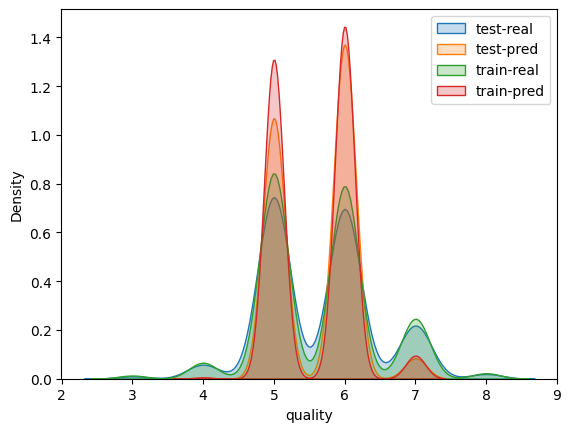

In [18]:
y_train_pred = np.around(best_model.predict(X_train), 0)
y_test_pred = np.around(best_model.predict(X_test), 0)
sns.kdeplot(y_test, fill=True, label='test-real')
sns.kdeplot(y_test_pred, fill=True, label='test-pred')
sns.kdeplot(y_train, fill=True, label='train-real')
sns.kdeplot(y_train_pred, fill=True, label='train-pred')
plt.legend()

**Хоч і за попередньою оцінкою модель і повинна показувати себе краще на тренувальних даних, за графіком тестувальні дані ближче до нормального розподілу по осі абсцис, а тренувальні ближче до реальних значень, знов є чіткі викиди по центру**

**Перейдемо до білих вин і повторимо те ж саме**

In [19]:
scaler = StandardScaler()
data_white_sc = scaler.fit_transform(data_white.drop(columns='quality'))
X_train, X_test, y_train, y_test = train_test_split(data_white_sc, data_white.quality, train_size=.66, random_state=17, shuffle=True, stratify=data_white.quality)

reg = LinearRegression()

cv_sc = cross_val_score(reg, X_train, y_train, cv=4)
print(f"Cross-Validation Scores: {cv_sc}")

Cross-Validation Scores: [0.27090531 0.27269612 0.24081695 0.29558229]


**На крос валідації видно, що дані збалансовані доволі непогано, сильних відхилів не спостерігається**

In [20]:
reg.fit(X_train, y_train)

print(f'Train Score: {reg.score(X_train, y_train)}')
print(f'Test Score: {reg.score(X_test, y_test)}')
error_est(reg, X_train, X_test, y_train, y_test)

Train Score: 0.2738589530144927
Test Score: 0.2680794382995829


{'MSE Train': 0.643,
 'MSE Test': 0.661,
 'RMSE Train': 0.802,
 'RMSE Test': 0.813,
 'MAE Train': 0.531,
 'MAE Test': 0.544}

**Train i Test score в нормі - проміжку 0.25-0.4 та показники помилок хоч і великі але зходяться у тесті і трейні тобто модель не перенавчена**

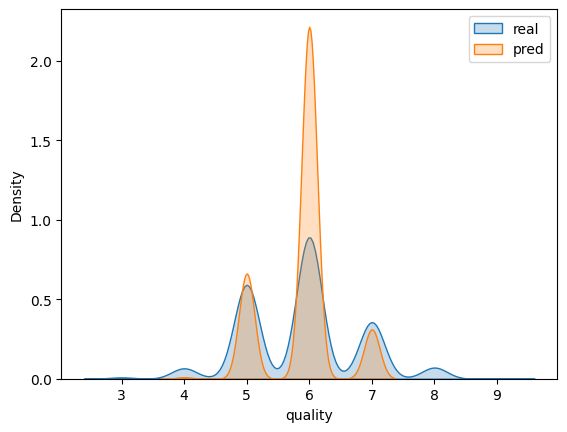

In [21]:
sns.kdeplot(y_test, fill=True, label='real')
sns.kdeplot(np.around(reg.predict(X_test), 0), fill=True, label='pred')
plt.legend()

**Графік схож на реальні значення, розподіл близький до реального, але на жаль, не охоплює крайні значення та знову ж викид по центру**

In [22]:
sgd_reg = SGDRegressor(penalty='elasticnet')
# penalty elasticnet поєднує в собі l1 i l2 регуляризацію
param_grid = {
    'alpha': np.linspace(0.001, 2, 100),
    'l1_ratio': np.linspace(0.01, 0.99, 10),
    'random_state': [17, 42],
}
grid_search_cv = GridSearchCV(sgd_reg, param_grid, cv=4, scoring='neg_mean_squared_error')
grid_search_cv.fit(X_train, y_train)
best_model = grid_search_cv.best_estimator_



print("Best Model:", best_model)

error_est(best_model, X_train, X_test, y_train, y_test)

Best Model: SGDRegressor(alpha=0.021191919191919192, l1_ratio=0.22777777777777777,
             penalty='elasticnet', random_state=42)


{'MSE Train': 0.641,
 'MSE Test': 0.673,
 'RMSE Train': 0.8,
 'RMSE Test': 0.82,
 'MAE Train': 0.528,
 'MAE Test': 0.552}

**Не дивлячись на підібрані гіперпараметри перформанс моделі майже не змінився, модель майже не перенавчена, але відбувається немало помилок**

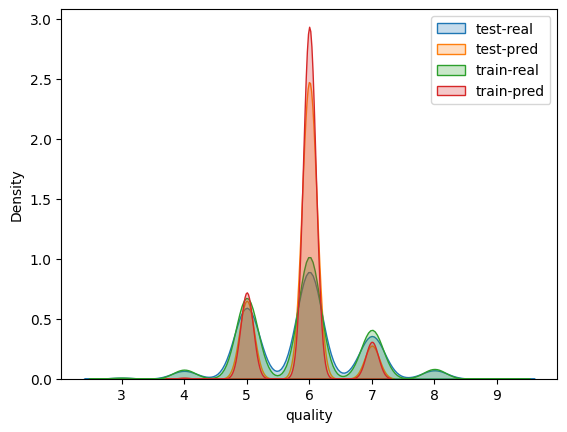

In [23]:
y_train_pred = np.around(best_model.predict(X_train), 0)
y_test_pred = np.around(best_model.predict(X_test), 0)
sns.kdeplot(y_test, fill=True, label='test-real')
sns.kdeplot(y_test_pred, fill=True, label='test-pred')
sns.kdeplot(y_train, fill=True, label='train-real')
sns.kdeplot(y_train_pred, fill=True, label='train-pred')
plt.legend()


**По графікам видно, що на тренувальних і тестових даних модель поводиться ідентично, виключенням є різниця в висоті по ординаті в якості - 6. В цілому модель справляється з основною задачею, але допускає багато помилок в крайніх значеннях**

***Отже, моделі є робочими, роблять помилки у крайніх значеннях, але не перенавчені, трейн та тест скори і помилки збігаються з невеликими відхиленнями***